In [2]:
%pip install tensorflow --user

  Using cached tensorflow-2.16.1-cp311-cp311-win_amd64.whl (2.1 kB)
  Using cached tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl (377.0 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl (26 kB)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ---------------------------------------- 0.0/26.4 MB ? eta -:--:--
     ---------------------------------------- 0.1/26.4 MB 2.2 MB/s eta 0:00:12
     ---------------------------------------- 0.1/26.4 MB 1.7 MB/s eta 0:00:16
     ---------------------------------------- 0.2/26.4 MB 1.6 MB/s eta 0:00:17
     ---------------------------------------- 0.3/26.4 MB 1.6 MB/s eta 0:00:17
      --------------------------------------- 0.4/26.4 MB 1.6 MB/s eta 0:00:17
      --------------------------------------- 0.4/26.4 MB 1.5 MB/s eta 0:00:18
      --------------------------------------- 0.5/26.4 MB 1.6 MB/s eta 0:00

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\razva\AppData\Roaming\Python\Python311\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\razva\AppData\Roaming\Python\Python311\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\razva\AppData\Roaming\Python\Python311\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\razva\AppData\Roaming\Python\Python311\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\http\client.py", line 465, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\socket.py", line 706, in readinto
    retur

In [3]:
import yfinance as yf
import GetOldTweets3 as got
import requests
import pytrends
from ta import add_all_ta_features
import praw
import pandas as pd
import os
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import keras
from io import StringIO
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense


ModuleNotFoundError: No module named 'tensorflow'

<Figure size 1000x800 with 0 Axes>

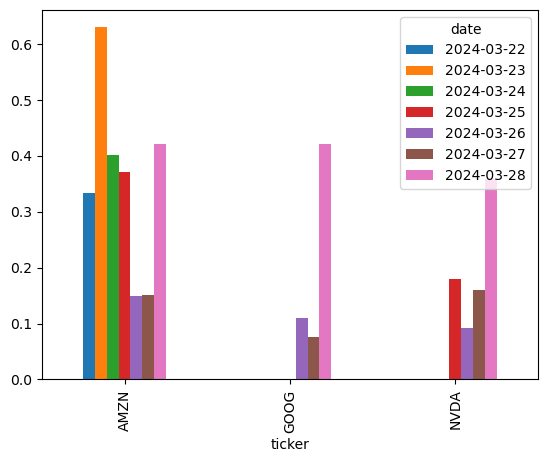

In [ ]:
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['AMZN', 'GOOG', 'NVDA']

news_tables = {}
for ticker in tickers:
    url = finviz_url + ticker

    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)

    html = BeautifulSoup(response, features='html.parser')
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

parsed_data = []

for ticker, news_table in news_tables.items():

    for row in news_table.findAll('tr'):
   
        title = row.a.text
        date_data = re.split(r'\s+', row.td.text.strip())
 
        if len(date_data) == 1:
            time = date_data[0]
        else:
            if date_data[0] == 'Today':
                date = datetime.now().strftime('%b-%d-%y')
            else:
                date = date_data[0]
            time = date_data[1]

        parsed_data.append([ticker, date, time, title])

df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])

vader = SentimentIntensityAnalyzer()

f = lambda title: vader.polarity_scores(title)['compound']
df['compound'] = df['title'].apply(f)

df['date'] = pd.to_datetime(df.date).dt.date

plt.figure(figsize=(10,8))
mean_df = df.groupby(['ticker', 'date']).mean(numeric_only=True).unstack()
mean_df = mean_df.xs('compound', axis="columns")
mean_df.plot(kind='bar')
plt.show()

In [ ]:
AMZN = yf.Ticker("AMZN")

AMZN = AMZN.history(start='2020-01-01',end='2024-03-27')

In [ ]:
amzn = AMZN[['Close', 'Volume']]
amzn.index = amzn.index.tz_localize(None)
sentiment_transposed = mean_df.T
sentiment_transposed.index = pd.to_datetime(sentiment_transposed.index)

# Merge DataFrames
merged_df = pd.merge(amzn, sentiment_transposed[['AMZN']], left_index=True, right_index=True, how='left')
merged_df = merged_df.rename(columns={'AMZN': 'Sentiment'})
merged_df['Sentiment'] = merged_df['Sentiment'].fillna(0)
display(merged_df)


,Close,Volume,Sentiment
Date,,,
2020-01-02,94.900497,80580000,0.000000
2020-01-03,93.748497,75288000,0.000000
2020-01-06,95.143997,81236000,0.000000
2020-01-07,95.343002,80898000,0.000000
2020-01-08,94.598503,70160000,0.000000
...,...,...,...
2024-03-20,178.149994,29947200,0.000000
2024-03-21,178.149994,32824300,0.000000
2024-03-22,178.869995,27964100,0.334300


In [ ]:
merged_df=merged_df[['Close','Sentiment']]
display(merged_df)

,Close,Sentiment
Date,,
2020-01-02,94.900497,0.000000
2020-01-03,93.748497,0.000000
2020-01-06,95.143997,0.000000
2020-01-07,95.343002,0.000000
2020-01-08,94.598503,0.000000
...,...,...
2024-03-20,178.149994,0.000000
2024-03-21,178.149994,0.000000
2024-03-22,178.869995,0.334300


In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
split_idx = int(len(merged_df) * 0.8)

train_df = merged_df.iloc[:split_idx]
test_df = merged_df.iloc[split_idx:]


training_set_scaled = sc.fit_transform(train_df)

#training_set_scaled = training_set_scaled[:2]
display(training_set_scaled)

array([[0.1248729 , 0.        ],
       [0.11387533, 0.        ],
       [0.12719746, 0.        ],
       ...,
       [0.32152593, 0.        ],
       [0.34682415, 0.        ],
       [0.3286858 , 0.        ]])

In [ ]:
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
25/25 [==============================] - 11s 61ms/step - loss: 0.0685
Epoch 2/10
25/25 [==============================] - 1s 60ms/step - loss: 0.0196
Epoch 3/10
25/25 [==============================] - 1s 59ms/step - loss: 0.0143
Epoch 4/10
25/25 [==============================] - 2s 66ms/step - loss: 0.0140
Epoch 5/10
25/25 [==============================] - 2s 83ms/step - loss: 0.0123
Epoch 6/10
25/25 [==============================] - 2s 89ms/step - loss: 0.0117
Epoch 7/10
25/25 [==============================] - 2s 88ms/step - loss: 0.0121
Epoch 8/10
25/25 [==============================] - 2s 86ms/step - loss: 0.0110
Epoch 9/10
25/25 [==============================] - 2s 87ms/step - loss: 0.0101
Epoch 10/10
25/25 [==============================] - 2s 85ms/step - loss: 0.0103


In [ ]:
dataset_total = merged_df
inputs = dataset_total[len(dataset_total) - len(test_df) - 60:].values
#inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 76):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = model.predict(X_test)
#predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Create a temporary array with the correct shape expected by the scaler
temp_array = np.zeros((predicted_stock_price.shape[0], 2))  # Shape (16, 2) to match the scaler

# Place the predicted stock prices into the first column of the temporary array
temp_array[:, 0] = predicted_stock_price.ravel()  # Assuming predictions correspond to the 'Close' prices

# Perform the inverse transformation on the adjusted array
inverse_transformed_array = sc.inverse_transform(temp_array)

# Extract the inverse transformed 'Close' prices, now correctly scaled
corrected_predicted_stock_price = inverse_transformed_array[:, 0]

# corrected_predicted_stock_price now contains the 'Close' prices after inverse transformation
predicted_stock_price = corrected_predicted_stock_price

real_stock_price = test_df['Close'].values

1/1 [==============================] - 0s 55ms/step


C:\Users\razva\anaconda3\envs\aiclasses\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
display(predicted_stock_price)
display(real_stock_price)

array([112.77494299, 113.68719149, 114.65231094, 115.63410084,
       116.59164054, 117.51427217, 118.41120509, 119.28934472,
       120.16139682, 121.04324516, 121.94931873, 122.89160527,
       123.84258917, 124.77622206, 125.66335249, 126.49493348])

array([115.01000214, 114.98999786, 116.75      , 115.        ,
       120.11000061, 121.66000366, 120.58000183, 122.76999664,
       124.25      , 125.30000305, 126.61000061, 121.23000336,
       124.25      , 123.43000031, 126.56999969, 126.66000366,
       126.41999817, 127.11000061, 125.48999786, 125.77999878,
       124.83000183, 130.1499939 , 129.33000183, 127.33000183,
       129.17999268, 129.03999329, 127.90000153, 130.36000061,
       130.22000122, 130.38000488, 128.36000061, 129.77999878,
       127.12999725, 128.77999878, 130.80000305, 134.30000305,
       134.67999268, 133.55999756, 132.83000183, 135.36000061,
       129.96000671, 130.        , 128.80000305, 129.13000488,
       128.1499939 , 128.25      , 132.21000671, 133.67999268,
       131.69000244, 128.21000671, 128.91000366, 139.57000732,
       142.22000122, 139.94000244, 137.8500061 , 138.55999756,
       138.41000366, 140.57000732, 137.66999817, 135.07000732,
       133.97999573, 133.22000122, 134.67999268, 134.25

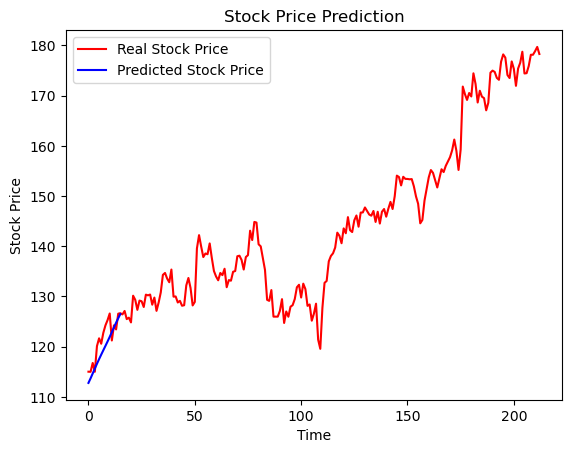

In [ ]:
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()